In [110]:
import numpy as np
from numpy import mean, std, dstack
from pandas import read_csv
from matplotlib import pyplot as plt, pyplot

import keras
from keras.layers import LSTM
from tensorflow.keras.layers import Activation, MaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization, concatenate
from keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# set seed to reproduce similar results
np.random.seed(0)

In [111]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/ex1/uard/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/ex1/uard/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [112]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [113]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


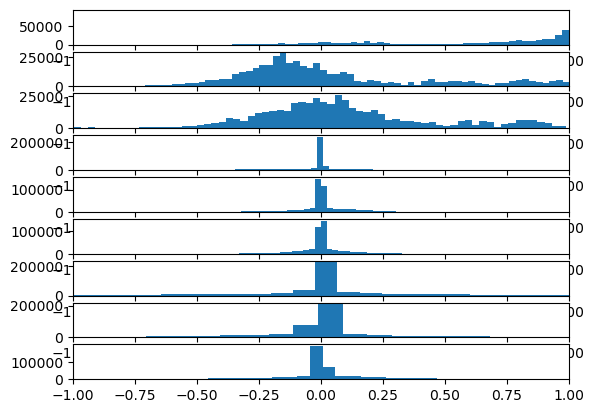

In [114]:
# plot distributions
plot_distributions(trainX)

In [115]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [116]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [117]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
92/92 [==============================] - 27s 234ms/step - loss: 1.2392 - accuracy: 0.4749 - val_loss: 1.0348 - val_accuracy: 0.5568
Epoch 2/10
92/92 [==============================] - 19s 212ms/step - loss: 0.7974 - accuracy: 0.6567 - val_loss: 0.7457 - val_accuracy: 0.6982
Epoch 3/10
92/92 [==============================] - 20s 213ms/step - loss: 0.6467 - accuracy: 0.7242 - val_loss: 0.7380 - val_accuracy: 0.7294
Epoch 4/10
92/92 [==============================] - 19s 204ms/step - loss: 0.5937 - accuracy: 0.7517 - val_loss: 0.7194 - val_accuracy: 0.7478
Epoch 5/10
92/92 [==============================] - 19s 207ms/step - loss: 0.4749 - accuracy: 0.8215 - val_loss: 0.5293 - val_accuracy: 0.8382
Epoch 6/10
92/92 [==============================] - 19s 212ms/step - loss: 0.3153 - accuracy: 0.8905 - val_loss: 0.4603 - val_accuracy: 0.8783
Epoch 7/10
92/92 [==============================] - 19s 210ms/step - loss: 0.2166 - accuracy: 0.9242 - val_loss: 0.3544 - val_accuracy: 0.8953

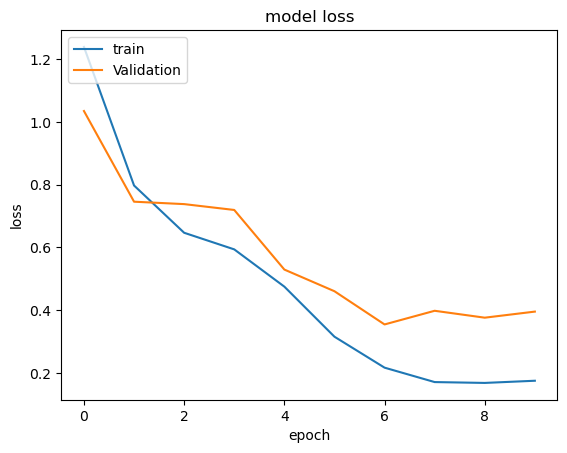

In [118]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [119]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8680013418197632
93/93 [==============================] - 5s 47ms/step


In [120]:
predictions

array([[9.2915271e-04, 1.7141338e-05, 9.8429728e-06, 1.0755268e-02,
        9.8828411e-01, 4.5012571e-06],
       [7.5081090e-04, 1.1668228e-05, 6.2479412e-06, 8.4975408e-03,
        9.9073118e-01, 2.5559198e-06],
       [7.1634218e-04, 1.0662229e-05, 5.6814429e-06, 7.7745970e-03,
        9.9149042e-01, 2.2444724e-06],
       ...,
       [9.5954270e-04, 9.9853909e-01, 4.6436046e-04, 2.0049440e-05,
        1.0687957e-05, 6.3870693e-06],
       [1.9184354e-03, 9.9715000e-01, 6.8106252e-04, 1.1432358e-04,
        6.5242755e-05, 7.0967326e-05],
       [1.4626228e-03, 9.9809867e-01, 3.4164425e-04, 4.4064367e-05,
        2.6977397e-05, 2.6144371e-05]], dtype=float32)

**** Confusion Matrix ****
[[483  10   3   0   0   0]
 [ 41 413  16   1   0   0]
 [ 92  11 317   0   0   0]
 [  0   2   0 407  78   4]
 [  4   0   0  85 443   0]
 [  0  42   0   0   0 495]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.78      0.97      0.87       496
           2       0.86      0.88      0.87       471
           3       0.94      0.75      0.84       420
           4       0.83      0.83      0.83       491
           5       0.85      0.83      0.84       532
           6       0.99      0.92      0.96       537

    accuracy                           0.87      2947
   macro avg       0.88      0.86      0.87      2947
weighted avg       0.88      0.87      0.87      2947



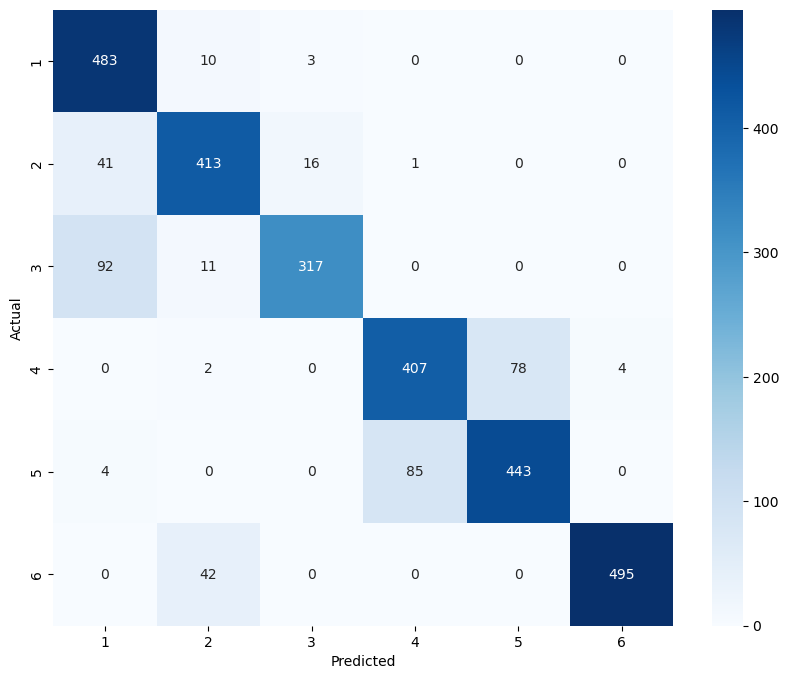

In [121]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [122]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/20
92/92 [==============================] - 6s 45ms/step - loss: 0.5042 - accuracy: 0.7973 - val_loss: 0.4575 - val_accuracy: 0.8994
Epoch 2/20
92/92 [==============================] - 4s 39ms/step - loss: 0.1760 - accuracy: 0.9322 - val_loss: 0.4241 - val_accuracy: 0.8511
Epoch 3/20
92/92 [==============================] - 4s 42ms/step - loss: 0.1337 - accuracy: 0.9452 - val_loss: 0.3233 - val_accuracy: 0.9150
Epoch 4/20
92/92 [==============================] - 4s 39ms/step - loss: 0.1010 - accuracy: 0.9572 - val_loss: 0.3215 - val_accuracy: 0.9143
Epoch 5/20
92/92 [==============================] - 4s 40ms/step - loss: 0.0946 - accuracy: 0.9590 - val_loss: 0.3251 - val_accuracy: 0.9096
Epoch 6/20
92/92 [==============================] - 4s 42ms/step - loss: 0.0906 - accuracy: 0.9611 - val_loss: 0.3621 - val_accuracy: 0.9109
Epoch 7/20
92/92 [==============================] - 4s 40ms/step - loss: 0.0826 - accuracy: 0.9614 - val_loss: 0.3453 - val_accuracy: 0.9048
Epoch 8/20
92

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

In [ ]:
display_results(testy,predictions,classNames)